<hr style="border:2px solid black"></hr>

# Initialization

In [2]:
%load_ext autotime
%matplotlib inline

from toolbox.initialize import *

# Set this for faster conversion to pandas
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.4 ms


<hr style="border:2px solid black"></hr>

# Load data

In [4]:
df_path = Config.Path.project_data_root / 'df_clean'
df = t.load_data_from_files(df_path, spark, method='parquet')

# Drop the column: "user_id_prefix".
df = df.drop('user_id_prefix')

# Set the flag that determines whether the middle results
# will be shown.
display_middle_results = True

# Display the table.
if display_middle_results:
    df.limit(100).toPandas().head(5)

Loading data from path: "/data/work/shared/s001284/Music_Project/resources/data/df_clean".
	Execution time: 19.89017 s.


,user_id,activity_id,activity_start_time,activity_duration,device_id,device_name,track_artist,track_title,track_album,track_player,track_start_time,track_duration,track_id,track_uri
0,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,シャンデリア・ワルツ,UNISON SQUARE GARDEN,Walkman,2016-07-09 04:48:46.629,348,None,content://media/external/audio/media/102343
1,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Maluma,Borro Cassette,Borro Cassette,Spotify,2015-10-01 14:43:32.389,216,spotify:track:2ocDZVhBiGCaaZRNW3fmSd,None
2,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,シュガーソングとビターステップ,UNISON SQUARE GARDEN,Walkman,2016-07-09 04:54:34.187,257,None,content://media/external/audio/media/102344
3,b6206ded-5249-43ae-96fe-6cede3baca09,35183207-c20f-4032-82bc-21c92b3f06cb-2015-10-01,2015-10-01 14:43:32.389,1305,263729c6c47127d4,D6603,Reykon,Imaginándote (feat. Daddy Yankee),Imaginándote (feat. Daddy Yankee),Spotify,2015-10-01 14:47:08.233,224,spotify:track:3AQ1zVx39FvB4yH0bjGgPm,None
4,b64429b5-59a1-4398-9276-6dc400815f8e,41aaa6e7-2c79-4c18-822f-77ec9dfa56a3-2016-07-09,2016-07-09 04:14:19.157,5056,771c4550615a05cd,SOV32,UNISON SQUARE GARDEN,流星のスコール,UNISON SQUARE GARDEN,Walkman,2016-07-09 04:59:12.033,307,None,content://media/external/audio/media/102337


time: 51.4 s


## Distinct values of `track_player`

In [ ]:
df_distinct_track_player = (
    df
    .select('track_player')
    .distinct()
)

n_distinct_track_players = df_distinct_track_player.count()
print(f'The number of distinct track players is: {n_distinct_track_players}')

# Display the table.
if display_middle_results:
    df_distinct_track_player.limit(100).toPandas().head(5)

In [11]:
distinct_track_players = t.spark.get_column(df_distinct_track_player, 'track_player')

time: 55.9 s


In [12]:
len(distinct_track_players)

4

time: 1.69 ms


## Types of `track_uri`

In [9]:
df_types_of_track_uri = (
    df
    .withColumn('track_uri_type',
                f.when(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/',
                     'internal_path')
                .otherwise(f.col('track_uri')))
    .select('track_uri_type')
    .distinct()
)

n_types_of_track_uri = df_types_of_track_uri.count()
print(f'The number of distinct track uri types is: {n_types_of_track_uri}')

The number of distinct track uri types is: 1748440
time: 4min 9s


In [ ]:
# Display the table.
if display_middle_results:
    df_types_of_track_uri.limit(100).toPandas().head(5)

## Types of `track_id`

In [ ]:
df_types_of_track_id = (
    df
    .withColumn('track_id_type',
                f.when(f.substring('track_id', 1, 7) == 'spotify',
                     'spotify_uri')
                .otherwise(f.col('track_id')))
    .select('track_id_type')
    .distinct()
)

n_types_of_track_id = df_types_of_track_id.count()
print(f'The number of distinct track uri types is: {n_types_of_track_id}')

## Rows where `track_uri` is a local path and the platform is not Walkman

In [29]:
df_a = (
    df
    .where(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/')
    .where(f.col('track_player') != 'Walkman')
)

# Display the table.
if display_middle_results:
    df_a.limit(100).toPandas().head(5)


,user_id,activity_id,activity_start_time,activity_duration,device_id,device_name,track_artist,track_title,track_album,track_player,track_start_time,track_duration,track_id,track_uri
0,7a749f71-6ccc-45bd-b4a2-782d3eb995ba,af8a5fea-5e76-4017-917c-c3d0821d60dc-2015-07-28,2015-07-28 11:42:58.521,493,3ab26f82656fe6f3,D6502,Green Day,409 In Your Coffee Maker,Transmissions,Music,2015-07-28 11:42:58.521,136,None,content://media/external/audio/media/2711
1,7a749f71-6ccc-45bd-b4a2-782d3eb995ba,af8a5fea-5e76-4017-917c-c3d0821d60dc-2015-07-28,2015-07-28 11:42:58.521,493,3ab26f82656fe6f3,D6502,Green Day,American Idiot,American Idiot,Music,2015-07-28 11:45:14.131,174,None,content://media/external/audio/media/2696
2,7a749f71-6ccc-45bd-b4a2-782d3eb995ba,af8a5fea-5e76-4017-917c-c3d0821d60dc-2015-07-28,2015-07-28 11:42:58.521,493,3ab26f82656fe6f3,D6502,Green Day,Basket Case,Dookie,Music,2015-07-28 11:48:08.627,183,None,content://media/external/audio/media/2706


time: 8min 50s


In [ ]:
df_b = (
    df
    .where(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/')
    .where(f.col('track_player') != 'Walkman')
)

# Display the table.
if display_middle_results:
    df_a.limit(100).toPandas().head(5)

In [ ]:
df_b = (
    df.withColumn('track_id_prefix', 
                 f.when(f.col('track_uri').isNull()))
    
    .where(f.substring('track_uri', 1, 37) == 'content://media/external/audio/media/')
    .where(f.col('track_player') != 'Walkman')
)

# Display the table.
if display_middle_results:
    df_a.limit(100).toPandas().head(5)

In [ ]:
df = (
    df
    .withColumnRenamed('track_id', 'track_spotify_uri')
    .withColumnRenamed('track_uri', 'track_sony_path')
)

## Count the rows

In [ ]:
n_rows_total = df.count()

print(f'The total number of rows: {n_rows_total:,.0f}.')

<hr style="border:2px solid black"></hr>

# Statistics

## Visualize the amount of undefined cells in each column

### As table

Count the undefined cells in each column:

In [4]:
## COUNT THE UNDEFINED CELLS

# Initialize the dict where the numbers will be stored.
n_undefined = dict()
pct_undefined = dict()

# Count the undefined cells in each column.
for column_name in tqdm(df.columns):
    n_undefined[column_name] = df.where(f.col(column_name).isNull()).count()
    pct_undefined[column_name] = n_undefined[column_name] / n_rows_total * 100

    
## DISPLAY RESULTS AS PANADAS TABLE

# Define the column names.
property_names = ['Number of cells', 'Percent of total'] 

# Create a dict representing the data.
data = {column_name: [f'{n_undefined[column_name]:,.0f}',
                      f'{pct_undefined[column_name]:.2f}']
        for column_name in n_undefined.keys()}

# Create the pandas dataframe for displaying.
dfp_undefined = pd.DataFrame.from_dict(data,
                                       orient='index',
                                       columns=property_names)

# Display the dataframe
display(dfp_undefined)

100%|██████████| 14/14 [05:48<00:00, 24.87s/it]


,Number of cells,Percent of total
user_id,0,0.00
activity_id,0,0.00
activity_start_time,0,0.00
activity_duration,0,0.00
device_id,"7,253,534",0.29
device_name,"7,258,178",0.29
track_artist,"710,429,434",28.07
track_title,"180,364,595",7.13
track_album,"127,804,616",5.05
track_player,"338,135,480",13.36


time: 5min 48s


In [5]:
t.save_table(dfp_undefined, 'undefined_cells_in_full_database')

Saving table to: "/data/work/shared/s001284/Music_Project/documentation/report/resources/tables/undefined_cells_in_full_database.tex".
	Done.
time: 10.8 ms


### As bargraph

Create a bargraph represening the percentage of undefined cells in each column:

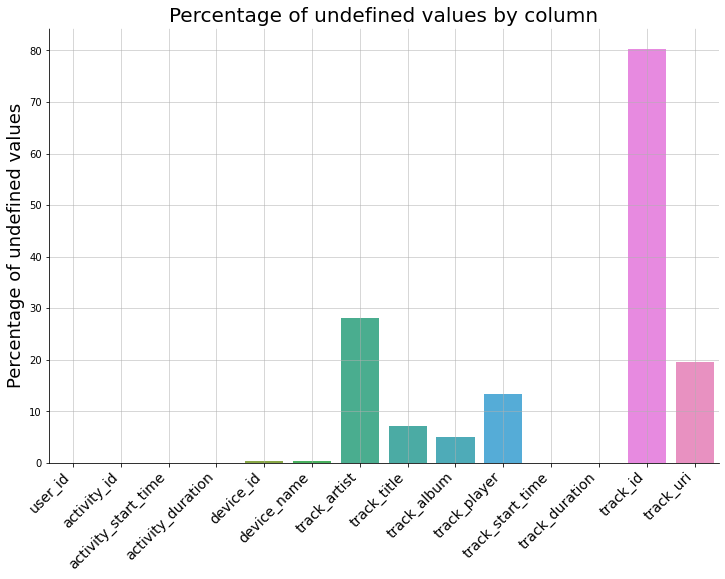

time: 439 ms


In [22]:
# Create a barplot showing the percentage of undefined values in each column.
axes = sns.barplot(x=list(pct_undefined.keys()),
                   y=list(pct_undefined.values()))

# Rotate the tick labels for the x-axes.
labels = axes.set_xticklabels(axes.get_xticklabels(),
                              rotation=45,
                              ha='right',
                              va='top',
                              fontsize=14
                             )

# Annotate the graph.
title = axes.set_title('Percentage of undefined values by column')
# x_label = axes.set_xlabel('Column name')
y_label = axes.set_ylabel('Percentage of undefined values')

# Apply general formatting.
w.format_figure(axes.figure)

# Save the figure
# t.save_plot('percentage_of_undefined_cells_in_full_database')
plt.savefig(Config.Path.report_images_root / 'percentage_of_undefined_cells_in_full_database.eps')

## Visualize activities over time

In [17]:
# Compute dataframe showing the number of activities and the total duration
# of these activities per day. Order by activity date.
df_activity_stats = (
    df
    .withColumn('activity_date', f.to_date('activity_start_time'))
    .groupBy('activity_date')
    .agg(f.count('activity_id').alias('n_activities'),
         f.sum('activity_duration').alias('activity_duration_sum'))
    .orderBy(f.asc('activity_date'))
)

# Show the top rows
df_activity_stats.limit(100).toPandas().head(10)

,activity_date,n_activities,activity_duration_sum
0,1970-01-01,1,15
1,1970-02-01,13,20683
2,2000-01-01,17,35343
3,2013-06-11,3,873
4,2013-08-21,1,13
5,2013-09-04,1,1
6,2013-09-14,5,2008
7,2013-09-20,1,8
8,2013-09-26,12,26184
9,2013-09-28,1,18


time: 2min 42s


In [18]:
# # Histogram
# buckets = [int(10*1.2**i) for i in range(0,30)]
# price_histogram = df_listings_rome.select('price').rdd.flatMap(lambda x: x).histogram(buckets)

def get_column(df, column_name):
    return df.select(column_name).rdd.flatMap(lambda x: x).collect()

date = get_column(df_activity_stats, 'activity_date')
n_activities = get_column(df_activity_stats, 'n_activities')
duration_sum = get_column(df_activity_stats, 'activity_duration_sum')

time: 6min 28s


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


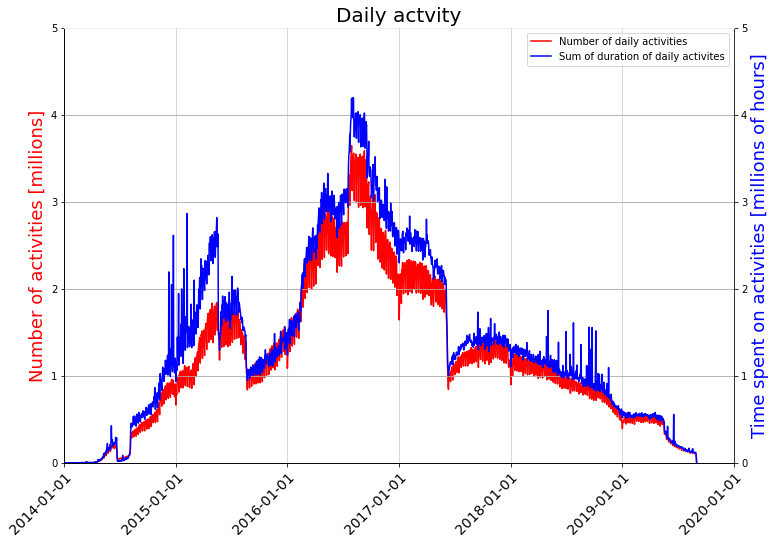

time: 470 ms


In [37]:
# Create a figure and axes for the plot.
figure, axes_left = w.empty_figure()

# Create a twin axes for two different y-axes on the same plot.
axes_right = axes_left.twinx()

# Plot the data
plot_left = axes_left.plot(date, np.array(n_activities) / 1e6,
                      color='red',
                      label='Number of daily activities')

plot_right = axes_right.plot(date, np.array(duration_sum) / (3600 * 1e6),
                         color='blue',
                         label='Sum of duration of daily activites')

# Set titles and labels.
title = axes_left.set_title('Daily actvity')
xlabel = axes_left.set_xlabel('')
ylabel_left = axes_left.set_ylabel('Number of activities [millions]')
ylabel_right = axes_right.set_ylabel('Time spent on activities [millions of hours]')

# Set tickmarks.
axes_left.xaxis.set_major_locator(mdates.YearLocator(1, month=1, day=1))
x_lim = axes_left.set_xlim((datetime.datetime(2014, 1, 1), datetime.datetime(2020, 1, 1)))
plot = plt.setp(axes_left.get_xticklabels(),
                rotation=45,
                ha="right",
                va='top',
                rotation_mode="anchor",
                fontsize=14)

# Set limits
y_lim_left = axes_left.set_ylim((0, 5))
y_lim_right = axes_right.set_ylim((0, 5))

# Set layout
axes = figure.axes
for ax in axes:
    ax.spines['top'].set_color('white')
    ax.set_facecolor("white")
    ax.xaxis.label.set_fontsize(18)
    ax.yaxis.label.set_fontsize(18)
    ax.title.set_fontsize(20)
    
axes_left.yaxis.label.set_color('red')
axes_right.yaxis.label.set_color('blue')

# Set grid
axes_left.xaxis.grid(which="both", linewidth=0.5)
axes_left.yaxis.grid(which="both", linewidth=0.5)
axes_right.grid(None)

# Add a legend
all_plots = plot_left + plot_right
all_labels = [plot.get_label() for plot in all_plots]
legend = axes_left.legend(all_plots, all_labels, loc=0)

# Save the figure
# t.save_plot('daily_activity_vs_time')
figure.savefig(Config.Path.report_images_root / 'daily_activity_vs_time.eps')

<hr style="border:2px solid black"></hr>

# Save the dataframe

In [ ]:
# Save the start time for timing.
start_time = time.time()

# Save the dataframe with partitions defined by the first
# two letters of the user ID.
(df
 .withColumn('user_id_prefix', f.col('user_id').substr(0,2))
 .write.mode('overwrite')
 .partitionBy('user_id_prefix')
 .parquet(str(Config.Path.project_data_root / 'df_clean_new'))
)

# Print the execution time.
print(f'Execution time: {time.time() - start_time:.5f} s.')